In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# from statsmodels.tsa.arima.model import ARMA, ARIMA, ARMAResults, ARIMAResults

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults

# arma not separaelty included just set d = 0 to use arma

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
# ! pip install pmdarima

In [8]:
from pmdarima import auto_arima


In [39]:
df1 = pd.read_csv("../../Data/DailyTotalFemaleBirths.csv", index_col = 'Date', parse_dates = True)
df1.index.freq = 'D'

In [40]:
df1 = df1[:120]
# FIRST four months are stationary thats why this taken

In [43]:
df2 = pd.read_csv("../../Data/TradeInventories.csv", index_col = 'Date', parse_dates = True)
df2.index.freq = 'MS'

### ARMA

<Axes: xlabel='Date'>

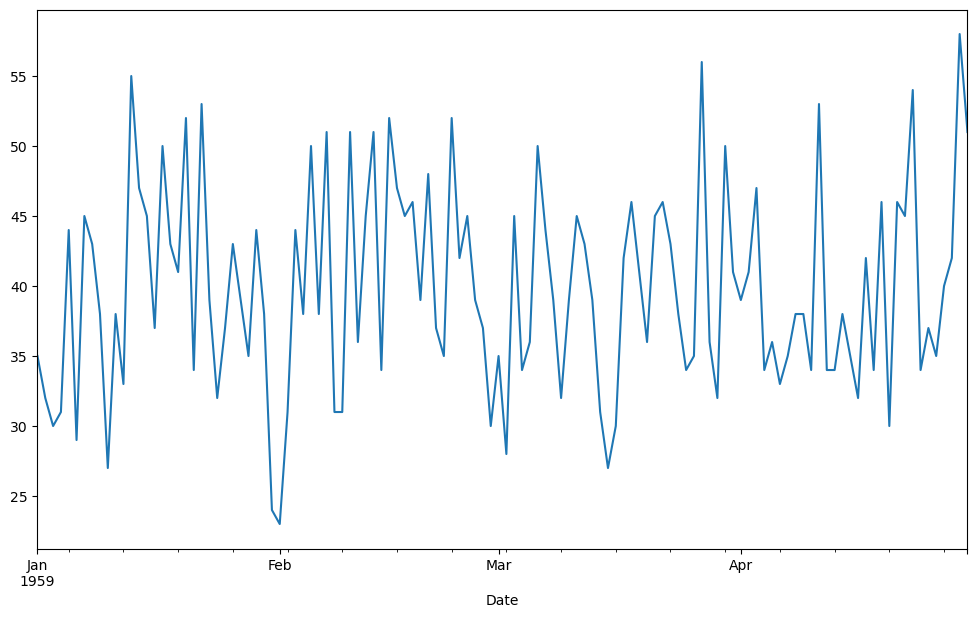

In [44]:
df1['Births'].plot(figsize = (12,7))

In [45]:
## does not look like data has clear seasonality / trend

In [46]:
## dicky fuller to test the stationarity

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [47]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [48]:
# auto_arima(df1['Births'], sesonal = False, start_p = 0 , end_p = 4 , start_q = 0 , end_q = 4).summary()

auto_arima(df1['Births'], sesonal = False, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=829.623, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=823.489, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=824.647, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=824.747, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1230.607, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=826.399, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.687 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Mon, 23 Sep 2024   AIC                            823.489
Time:                        22:42:02   BIC                            829.064
Sample:                    01-01-1959   HQIC                           825.753
                         - 04-30-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.36   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
## best model is ARIMA but lets try using ARMA ON it

In [50]:
## split into train and test 
## we want to do 1 month forecast so test size = 1 month 
train = df1.iloc[:90]
test = df1.iloc[90:]

In [51]:
model = ARIMA(train, order=(2, 0, 2))
# D= 0 MAKEs it ARMA

In [52]:
results = model.fit()

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -307.812
Date:                Mon, 23 Sep 2024   AIC                            627.625
Time:                        22:42:03   BIC                            642.624
Sample:                    01-01-1959   HQIC                           633.673
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7578      1.017     39.095      0.000      37.765      41.751
ar.L1         -0.4667      1.005     -0.464      0.642      -2.437       1.503
ar.L2          0.5073      0.942      0.539      0.590      -1.339       2.353
ma.L1          0.5626      4.157      0.135      0.892      -7.584       8.709
ma.L2         -0.4370      1.890     -0.231      0.817      -4.141       3.267
sigma2        54.3913    204.505      0.266      0.790    -346.432     455.214
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.96   Prob(JB):                         0.37
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
start = len(train)
end = len(train) +len(test)-1
predictions = results.predict(start, end).rename('ARMA (2,2) RESULTS')

<Axes: xlabel='Date'>

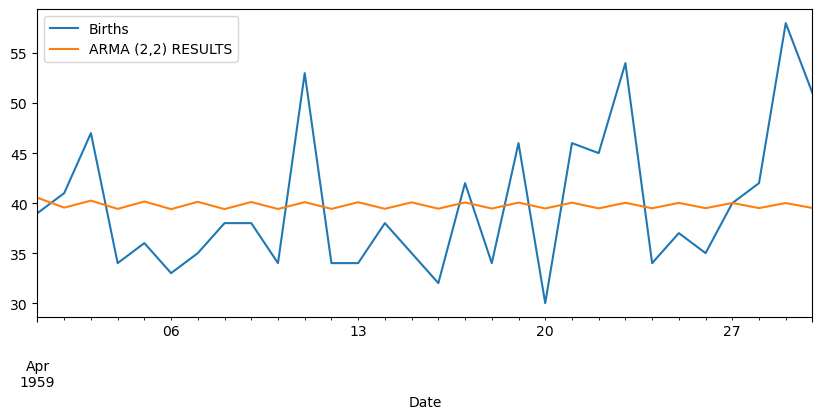

In [55]:
test['Births'].plot(figsize = (10,4), legend = True)
predictions.plot(figsize = (10,4), legend = True)

In [56]:
test.mean()

Births    39.833333
dtype: float64

In [57]:
predictions.mean()

39.78611132508333

In [58]:
# modelwas not able to predict the noice but was able to predict the range/ mean

### ARIMA

<Axes: xlabel='Date'>

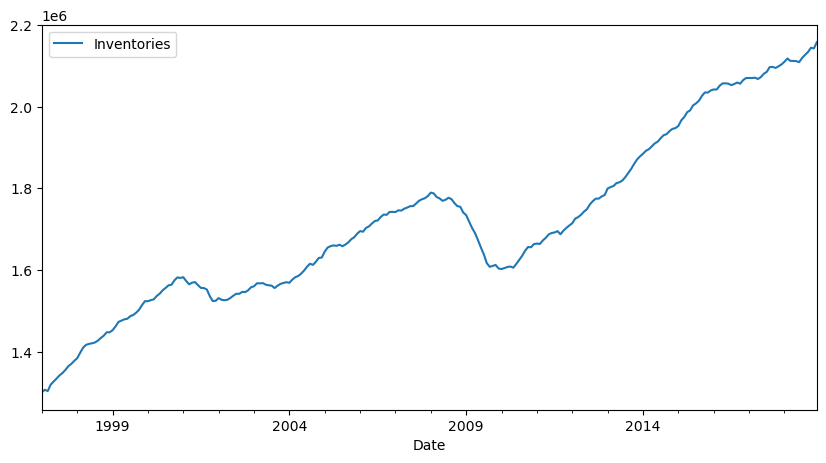

In [59]:
df2.plot(figsize = (10,5))

In [60]:
# check stationarity
adf_test(df2['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [61]:
# checkin seasonality 
from statsmodels.tsa.seasonal import seasonal_decompose

In [62]:
result = seasonal_decompose(df2['Inventories'], model = 'add')

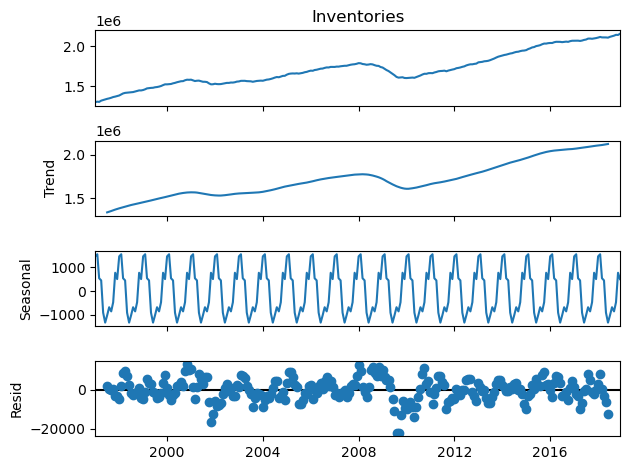

In [63]:
result.plot();

In [64]:
## see seasonality is between -1000 to 1000 which is a very small range compared to overall data 
## can use arima/sarima in such cast

In [65]:
## in real life would prefer SARIMA


In [66]:
auto_arima(df2['Inventories'], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Mon, 23 Sep 2024   AIC                           5348.037
Time:                        22:42:08   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
# model is suggesting to use diff =1 1st order differencing

In [68]:
from statsmodels.tsa.statespace.tools import diff

In [69]:
df2['diff_1'] = diff(df2['Inventories'], k_diff =1 )

In [70]:
adf_test(df2['diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [71]:
## so as per the auto model the d =1 should be done to use the arima model which is also shown by dicky fuller

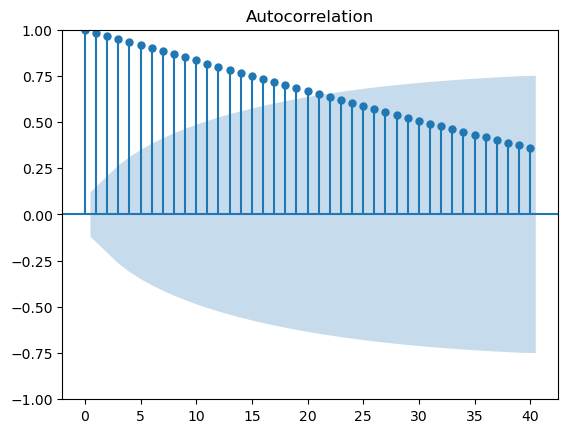

In [72]:
plot_acf(df2['Inventories'], lags = 40);


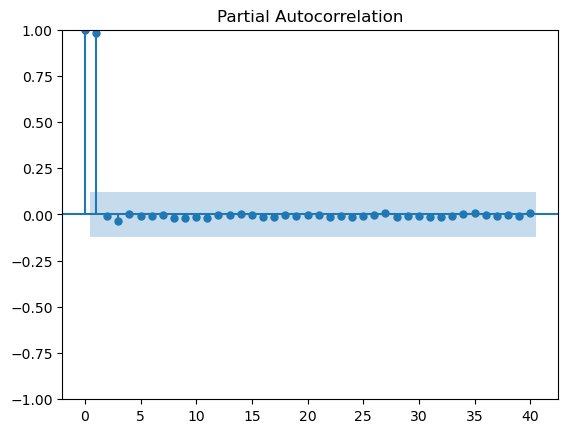

In [73]:
plot_pacf(df2['Inventories'], lags = 40 );

In [74]:
stepwise_fit = auto_arima(df2['Inventories'], start_p = 0 , start_q = 0 , max_p = 2, max_q=2,
                        seasonal = False, trace = True)

# 110 which is chosen via graph is also quite good selection

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.351 seconds


In [75]:
len(df2)

264

In [76]:
# using last year for test set 
train= df2.iloc[:252]
test = df2.iloc[252:]

In [77]:
model = ARIMA(df2['Inventories'], order = (1,1,1))

In [78]:
results = model.fit()
results.summary()

C:\Users\thaku\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2678.169
Date:                Mon, 23 Sep 2024   AIC                           5362.337
Time:                        22:42:12   BIC                           5373.054
Sample:                    01-01-1997   HQIC                          5366.644
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.001    781.325      0.000       0.997       1.002
ma.L1         -0.9983      0.003   -391.688      0.000      -1.003      -0.993
sigma2      2.956e+07   6.48e-13   4.56e+19      0.000    2.96e+07    2.96e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.69   Jarque-Bera (JB):                93.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.11
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.52e+35. Standard errors may be unstable.
"""

In [79]:
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start = start, end = end, typ = 'levels').rename("ARIMA(1,1,1) PREDICTIONS")
# earlier we had the linear default here which would give output in terms of differencing we did 

In [80]:
test.head()
# if level not chosen output would be comparable to diff_1

,Inventories,diff_1
Date,,
2018-01-01,2110158,6407.0
2018-02-01,2118199,8041.0
2018-03-01,2112427,-5772.0
2018-04-01,2112276,-151.0
2018-05-01,2111835,-441.0


In [81]:
predictions

Date
2018-01-01    2.106802e+06
2018-02-01    2.113214e+06
2018-03-01    2.121262e+06
2018-04-01    2.115473e+06
2018-05-01    2.115315e+06
2018-06-01    2.114866e+06
2018-07-01    2.112318e+06
2018-08-01    2.122649e+06
2018-09-01    2.130208e+06
2018-10-01    2.137215e+06
2018-11-01    2.147693e+06
2018-12-01    2.146046e+06
Freq: MS, Name: ARIMA(1,1,1) PREDICTIONS, dtype: float64

<Axes: xlabel='Date'>

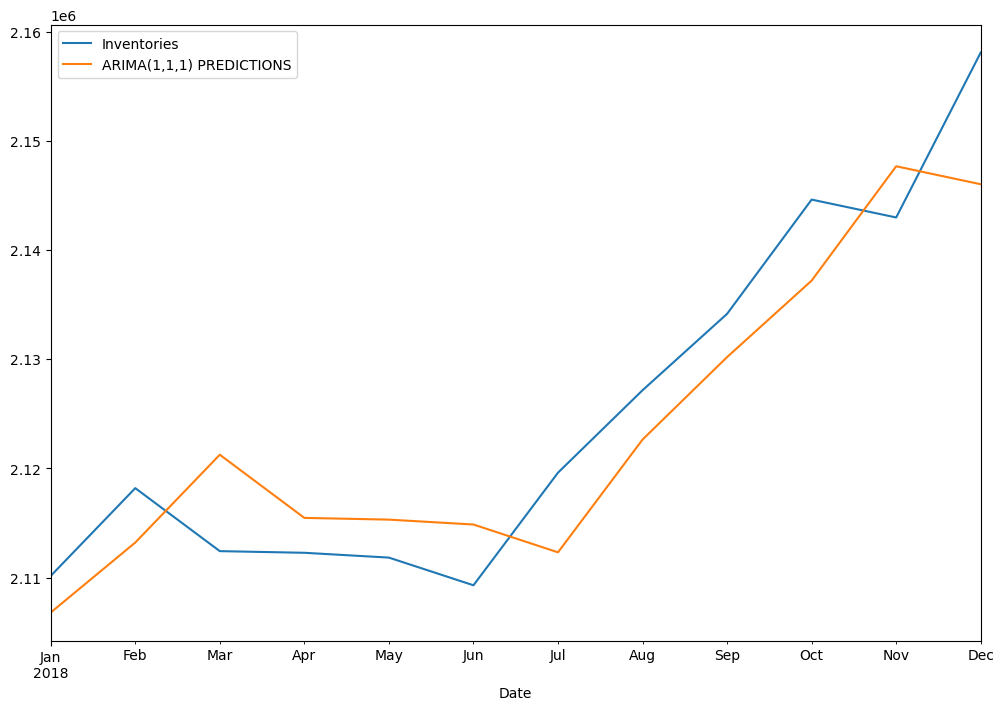

In [82]:
test['Inventories'].plot(legend = True, figsize = (12,8))
predictions.plot(legend = True)

In [83]:
# here since we are not using seasonality model might/ not be able to catch up that trend

In [84]:
from statsmodels.tools.eval_measures import rmse

In [85]:
error = rmse(test['Inventories'],predictions)

In [86]:
error

6322.912282231137

In [87]:
test['Inventories'].mean()

2125075.6666666665

In [88]:
# since the mean is in the order of milion while erorr is just in 1000's mean not a bad error

### forecast into the unknown future

In [89]:
model = ARIMA(df2['Inventories'], order = (1,1,1))

In [90]:
results = model.fit()

C:\Users\thaku\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
fcast = results.predict(start = len(df2), end = len(df2)+11, typ  = 'levels').rename("arima (1,1,1) forecast")

## end point can be anything but preferably choose equal to test set

<Axes: xlabel='Date'>

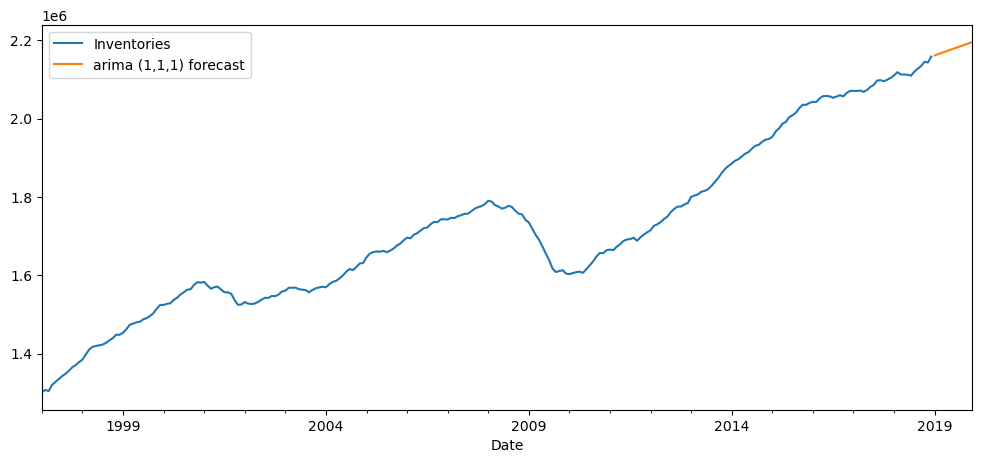

In [93]:
df2['Inventories'].plot(legend = True, figsize = (12,5))
fcast.plot(legend = True)